# PartObjaverse-Tiny Dataset Exploration

This notebook explores the 3D part segmentation dataset to understand:
- 3D mesh structure and properties
- Segmentation label formats (semantic and instance)
- Data statistics and distribution
- Visualization of meshes and segmentations

**Goal**: Understand the data challenges and preprocessing needs for 3D segmentation tasks.

In [20]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Overview

Let's explore the structure of our downloaded data.

In [21]:
# Define data paths
DATA_DIR = Path("../data/raw")
MESH_DIR = DATA_DIR / "PartObjaverse-Tiny_mesh"
SEMANTIC_GT_DIR = DATA_DIR / "PartObjaverse-Tiny_semantic_gt"
INSTANCE_GT_DIR = DATA_DIR / "PartObjaverse-Tiny_instance_gt"

# Get list of files
mesh_files = sorted(list(MESH_DIR.glob("*.glb")))
semantic_files = sorted(list(SEMANTIC_GT_DIR.glob("*.npy")))
instance_files = sorted(list(INSTANCE_GT_DIR.glob("*.npy")))

print(f"Total mesh files: {len(mesh_files)}")
print(f"Total semantic label files: {len(semantic_files)}")
print(f"Total instance label files: {len(instance_files)}")
print(f"\nAll counts match: {len(mesh_files) == len(semantic_files) == len(instance_files)}")

Total mesh files: 200
Total semantic label files: 200
Total instance label files: 200

All counts match: True


## 2. Load and Inspect a Single Sample

Let's load one mesh and its corresponding labels to understand the data format.

In [22]:
# Load first sample
sample_idx = 0
sample_mesh_path = mesh_files[sample_idx]
sample_id = sample_mesh_path.stem

print(f"Sample ID: {sample_id}")
print(f"Mesh file: {sample_mesh_path.name}")

# Load mesh using trimesh (handle Scene vs Mesh)
loaded = trimesh.load(sample_mesh_path)

# GLB files often contain a Scene with multiple meshes - extract the main mesh
if isinstance(loaded, trimesh.Scene):
    # Combine all meshes in the scene into one (use newer API)
    mesh = loaded.to_geometry()
    print(f"Loaded Scene with {len(loaded.geometry)} geometries, combined into single mesh")
else:
    mesh = loaded
    print(f"Loaded single mesh")

print(f"\nMesh properties:")
print(f"  Vertices: {len(mesh.vertices):,}")
print(f"  Faces: {len(mesh.faces):,}")
print(f"  Bounds: {mesh.bounds}")
print(f"  Is watertight: {mesh.is_watertight}")
print(f"  Volume: {mesh.volume:.4f}" if mesh.is_watertight else "  Volume: N/A (not watertight)")

print(f"\n💡 Note: 'Not watertight' is normal for multi-part objects.")
print(f"   This doesn't affect neural network training for segmentation!")

Sample ID: 00200996b8f34f55a2dd2f44d316d107
Mesh file: 00200996b8f34f55a2dd2f44d316d107.glb
Loaded Scene with 14 geometries, combined into single mesh

Mesh properties:
  Vertices: 20,784
  Faces: 35,900
  Bounds: [[-0.37084204 -0.5        -0.33181199]
 [ 0.48803657  0.50000691  0.33674118]]
  Is watertight: False
  Volume: N/A (not watertight)

💡 Note: 'Not watertight' is normal for multi-part objects.
   This doesn't affect neural network training for segmentation!


In [23]:
# Load semantic and instance labels
semantic_labels = np.load(SEMANTIC_GT_DIR / f"{sample_id}.npy")
instance_labels = np.load(INSTANCE_GT_DIR / f"{sample_id}.npy")

print(f"Semantic labels shape: {semantic_labels.shape}")
print(f"Instance labels shape: {instance_labels.shape}")
print(f"\nLabel assignment: One label per vertex")
print(f"Vertices: {len(mesh.vertices):,}, Labels: {len(semantic_labels):,}")

print(f"\nSemantic label statistics:")
print(f"  Unique semantic parts: {len(np.unique(semantic_labels))}")
print(f"  Semantic label range: [{semantic_labels.min()}, {semantic_labels.max()}]")

print(f"\nInstance label statistics:")
print(f"  Unique instances: {len(np.unique(instance_labels))}")
print(f"  Instance label range: [{instance_labels.min()}, {instance_labels.max()}]")

Semantic labels shape: (35900,)
Instance labels shape: (35900,)

Label assignment: One label per vertex
Vertices: 20,784, Labels: 35,900

Semantic label statistics:
  Unique semantic parts: 10
  Semantic label range: [0, 9]

Instance label statistics:
  Unique instances: 12
  Instance label range: [0, 11]


## 3. Visualize Mesh and Segmentation

Let's visualize the 3D mesh with its segmentation labels.

In [24]:
def visualize_mesh_plotly(mesh, vertex_colors=None, title="3D Mesh"):
    """
    Visualize a mesh using Plotly (interactive 3D visualization).
    
    Args:
        mesh: trimesh.Trimesh object
        vertex_colors: Optional per-vertex colors (labels will be converted to colors)
        title: Plot title
    """
    vertices = mesh.vertices
    faces = mesh.faces
    
    # Create color map if labels provided
    if vertex_colors is not None:
        # Normalize labels to [0, 1] for colormap
        unique_labels = np.unique(vertex_colors)
        color_map = plt.cm.get_cmap('tab20', len(unique_labels))
        colors = [color_map(i / len(unique_labels)) for i in range(len(unique_labels))]
        label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
        
        vertex_colors_rgb = np.array([label_to_color[label][:3] for label in vertex_colors])
        vertex_colors_rgb = (vertex_colors_rgb * 255).astype(int)
    else:
        vertex_colors_rgb = None
    
    # Create plotly figure
    fig = go.Figure(data=[
        go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            vertexcolor=vertex_colors_rgb if vertex_colors_rgb is not None else None,
            colorscale='Viridis' if vertex_colors_rgb is None else None,
            intensity=vertices[:, 2] if vertex_colors_rgb is None else None,
            showscale=False,
            opacity=1.0
        )
    ])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=600
    )
    
    return fig

In [25]:
# Visualize original mesh
fig = visualize_mesh_plotly(mesh, title=f"Original Mesh - {sample_id}")
fig.show()

In [26]:
# Visualize semantic segmentation
fig = visualize_mesh_plotly(mesh, vertex_colors=semantic_labels, 
                            title=f"Semantic Segmentation - {len(np.unique(semantic_labels))} parts")
fig.show()

/var/folders/vf/3k8xxh393sg6nq0z8r16v4m00000gn/T/ipykernel_69859/4087718822.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [27]:
# Visualize instance segmentation
fig = visualize_mesh_plotly(mesh, vertex_colors=instance_labels,
                            title=f"Instance Segmentation - {len(np.unique(instance_labels))} instances")
fig.show()

/var/folders/vf/3k8xxh393sg6nq0z8r16v4m00000gn/T/ipykernel_69859/4087718822.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



## 4. Dataset Statistics

Let's analyze the entire dataset to understand distributions and characteristics.

In [28]:
# Analyze multiple samples (this may take a few minutes)
print("Analyzing dataset statistics...")

stats = {
    'num_vertices': [],
    'num_faces': [],
    'num_semantic_parts': [],
    'num_instances': [],
    'is_watertight': [],
    'volume': []
}

# Sample subset for faster analysis (or use all if you want complete stats)
num_samples_to_analyze = min(50, len(mesh_files))  # Analyze first 50 samples

for i in tqdm(range(num_samples_to_analyze)):
    # Load mesh
    loaded = trimesh.load(mesh_files[i])
    
    # Handle Scene vs Mesh
    if isinstance(loaded, trimesh.Scene):
        mesh = loaded.to_geometry()
    else:
        mesh = loaded
    
    # Load labels
    sample_id = mesh_files[i].stem
    semantic = np.load(SEMANTIC_GT_DIR / f"{sample_id}.npy")
    instance = np.load(INSTANCE_GT_DIR / f"{sample_id}.npy")
    
    # Collect stats
    stats['num_vertices'].append(len(mesh.vertices))
    stats['num_faces'].append(len(mesh.faces))
    stats['num_semantic_parts'].append(len(np.unique(semantic)))
    stats['num_instances'].append(len(np.unique(instance)))
    stats['is_watertight'].append(mesh.is_watertight)
    stats['volume'].append(mesh.volume if mesh.is_watertight else np.nan)

# Convert to DataFrame for easier analysis
df_stats = pd.DataFrame(stats)
print(f"\nAnalyzed {num_samples_to_analyze} samples")
df_stats.describe()

Analyzing dataset statistics...


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


Analyzed 50 samples


,num_vertices,num_faces,num_semantic_parts,num_instances,volume
count,50.00000,50.000000,50.000000,50.000000,0.0
mean,28116.18000,30050.260000,7.620000,10.620000,NaN
std,31714.76271,37541.102842,2.898909,4.489853,NaN
min,904.00000,516.000000,3.000000,3.000000,NaN
25%,6962.00000,5214.000000,6.000000,8.000000,NaN
50%,14169.50000,15191.500000,7.000000,10.500000,NaN
75%,38418.50000,39054.000000,9.750000,13.750000,NaN
max,122042.00000,179132.000000,15.000000,23.000000,NaN


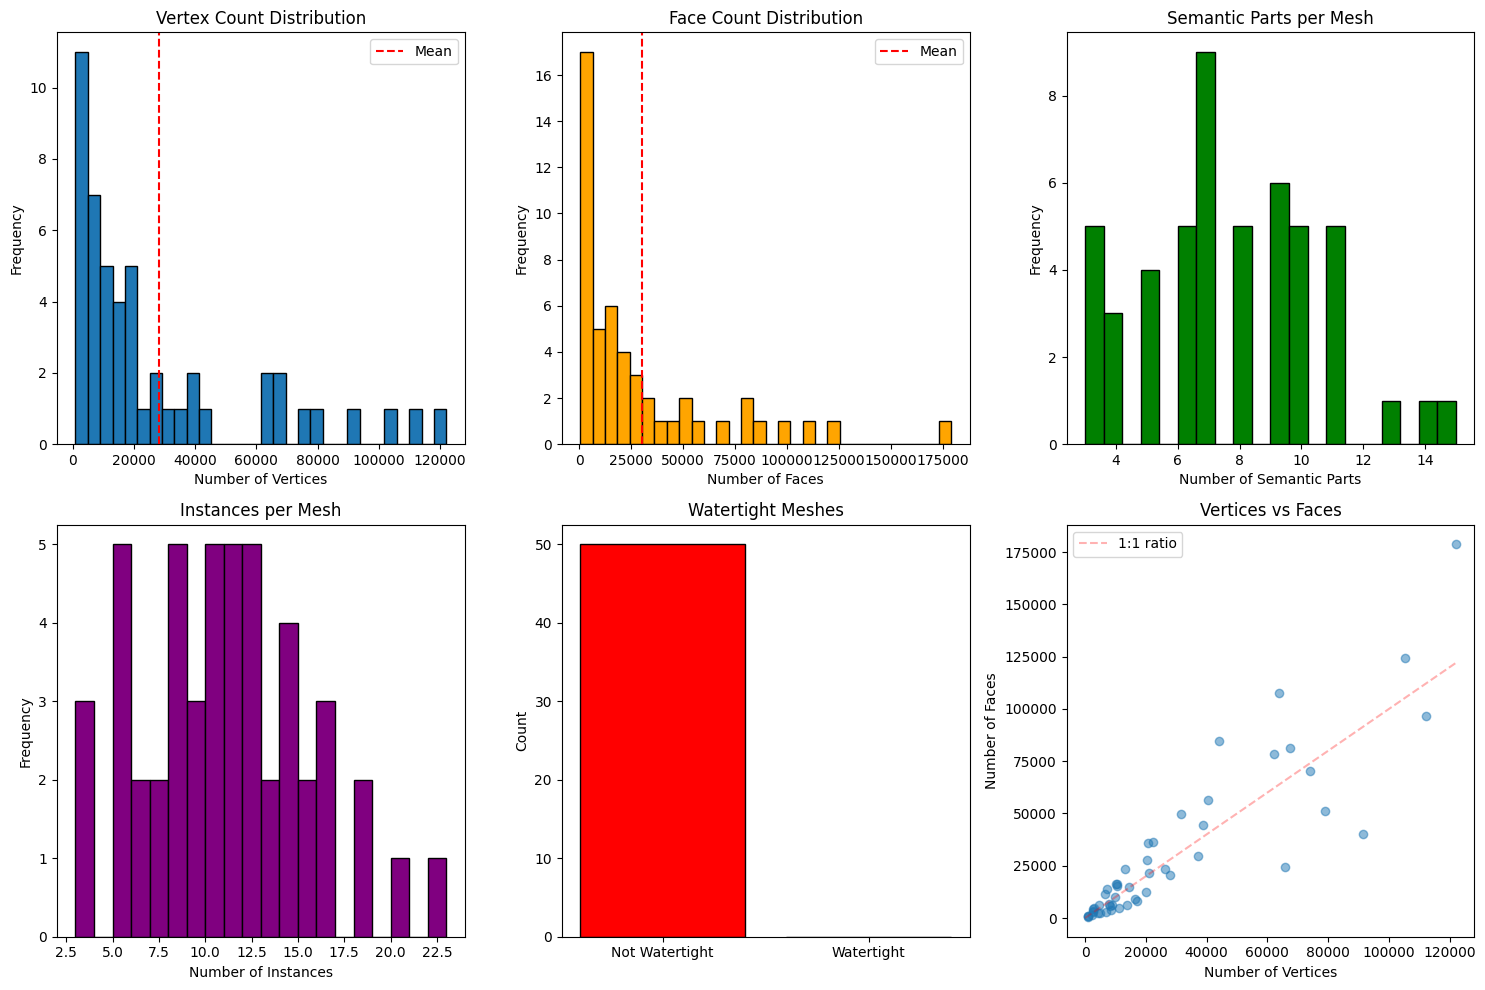

In [29]:
# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Vertices distribution
axes[0, 0].hist(df_stats['num_vertices'], bins=30, edgecolor='black')
axes[0, 0].set_xlabel('Number of Vertices')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Vertex Count Distribution')
axes[0, 0].axvline(df_stats['num_vertices'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Faces distribution
axes[0, 1].hist(df_stats['num_faces'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_xlabel('Number of Faces')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Face Count Distribution')
axes[0, 1].axvline(df_stats['num_faces'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Semantic parts distribution
axes[0, 2].hist(df_stats['num_semantic_parts'], bins=20, edgecolor='black', color='green')
axes[0, 2].set_xlabel('Number of Semantic Parts')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Semantic Parts per Mesh')

# Instance distribution
axes[1, 0].hist(df_stats['num_instances'], bins=20, edgecolor='black', color='purple')
axes[1, 0].set_xlabel('Number of Instances')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Instances per Mesh')

# Watertight percentage
watertight_counts = df_stats['is_watertight'].value_counts()
axes[1, 1].bar(['Not Watertight', 'Watertight'], 
               [watertight_counts.get(False, 0), watertight_counts.get(True, 0)],
               color=['red', 'green'], edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Watertight Meshes')

# Vertex to faces ratio
axes[1, 2].scatter(df_stats['num_vertices'], df_stats['num_faces'], alpha=0.5)
axes[1, 2].set_xlabel('Number of Vertices')
axes[1, 2].set_ylabel('Number of Faces')
axes[1, 2].set_title('Vertices vs Faces')
axes[1, 2].plot([0, df_stats['num_vertices'].max()], 
                [0, df_stats['num_vertices'].max()], 
                'r--', alpha=0.3, label='1:1 ratio')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## 5. Point Cloud Sampling

For neural network training, we often convert meshes to point clouds. Let's explore this conversion.

In [30]:
def sample_point_cloud(mesh, labels, num_points=2048):
    """
    Sample a point cloud from a mesh with corresponding labels.
    
    Args:
        mesh: trimesh.Trimesh object
        labels: per-vertex labels
        num_points: number of points to sample
    
    Returns:
        points: (N, 3) array of point coordinates
        sampled_labels: (N,) array of labels for each point
    """
    # Sample points from mesh surface
    points, face_indices = trimesh.sample.sample_surface(mesh, num_points)
    
    # Get vertex indices for each face
    face_vertices = mesh.faces[face_indices]
    
    # For each sampled point, assign label from one of the face's vertices
    # (simple approach: use first vertex of the face)
    sampled_labels = labels[face_vertices[:, 0]]
    
    return points, sampled_labels

In [31]:
# Sample point cloud from our example mesh
num_points = 2048
points, point_labels = sample_point_cloud(mesh, semantic_labels, num_points)

print(f"Point cloud shape: {points.shape}")
print(f"Point labels shape: {point_labels.shape}")
print(f"Points range: X[{points[:, 0].min():.2f}, {points[:, 0].max():.2f}], "
      f"Y[{points[:, 1].min():.2f}, {points[:, 1].max():.2f}], "
      f"Z[{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")

Point cloud shape: (2048, 3)
Point labels shape: (2048,)
Points range: X[-0.20, 0.20], Y[-0.50, 0.47], Z[-0.22, 0.22]


In [32]:
# Visualize point cloud
def visualize_point_cloud(points, labels=None, title="Point Cloud"):
    """
    Visualize a point cloud with optional labels.
    """
    fig = go.Figure(data=[
        go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=labels if labels is not None else points[:, 2],
                colorscale='Viridis' if labels is None else 'Rainbow',
                showscale=True
            )
        )
    ])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=600
    )
    
    return fig

fig = visualize_point_cloud(points, point_labels, 
                            title=f"Point Cloud ({num_points} points) with Semantic Labels")
fig.show()

## 6. Key Insights and Challenges

Let's summarize what we've learned about this dataset.

In [33]:
print("=" * 80)
print("KEY INSIGHTS FROM DATA EXPLORATION")
print("=" * 80)

print("\n1. DATASET SIZE:")
print(f"   - Total samples: {len(mesh_files)}")
print(f"   - Each sample has: mesh (.glb) + semantic labels (.npy) + instance labels (.npy)")

print("\n2. MESH CHARACTERISTICS (from analyzed subset):")
print(f"   - Avg vertices: {df_stats['num_vertices'].mean():.0f} (std: {df_stats['num_vertices'].std():.0f})")
print(f"   - Avg faces: {df_stats['num_faces'].mean():.0f} (std: {df_stats['num_faces'].std():.0f})")
print(f"   - Watertight meshes: {df_stats['is_watertight'].sum()}/{len(df_stats)} ({100*df_stats['is_watertight'].mean():.1f}%)")

print("\n3. SEGMENTATION COMPLEXITY:")
print(f"   - Avg semantic parts: {df_stats['num_semantic_parts'].mean():.1f} (range: {df_stats['num_semantic_parts'].min()}-{df_stats['num_semantic_parts'].max()})")
print(f"   - Avg instances: {df_stats['num_instances'].mean():.1f} (range: {df_stats['num_instances'].min()}-{df_stats['num_instances'].max()})")

print("\n4. CHALLENGES FOR NEURAL NETWORKS:")
print("   - Variable mesh sizes → Need fixed-size input (point cloud sampling)")
print("   - High vertex count → Memory constraints during training")
print("   - Different scales → Need normalization/standardization")
print("   - Varying number of parts → Need flexible segmentation heads")

print("\n5. PREPROCESSING NEEDS:")
print("   - Mesh → Point cloud conversion (e.g., 2048 or 4096 points)")
print("   - Normalization: center to origin, scale to unit sphere")
print("   - Data augmentation: rotation, jittering, scaling")
print("   - Label mapping: ensure consistent label indices")

print("\n" + "=" * 80)

KEY INSIGHTS FROM DATA EXPLORATION

1. DATASET SIZE:
   - Total samples: 200
   - Each sample has: mesh (.glb) + semantic labels (.npy) + instance labels (.npy)

2. MESH CHARACTERISTICS (from analyzed subset):
   - Avg vertices: 28116 (std: 31715)
   - Avg faces: 30050 (std: 37541)
   - Watertight meshes: 0/50 (0.0%)

3. SEGMENTATION COMPLEXITY:
   - Avg semantic parts: 7.6 (range: 3-15)
   - Avg instances: 10.6 (range: 3-23)

4. CHALLENGES FOR NEURAL NETWORKS:
   - Variable mesh sizes → Need fixed-size input (point cloud sampling)
   - High vertex count → Memory constraints during training
   - Different scales → Need normalization/standardization
   - Varying number of parts → Need flexible segmentation heads

5. PREPROCESSING NEEDS:
   - Mesh → Point cloud conversion (e.g., 2048 or 4096 points)
   - Normalization: center to origin, scale to unit sphere
   - Data augmentation: rotation, jittering, scaling
   - Label mapping: ensure consistent label indices



## 7. Next Steps

Based on this exploration, here's what to do next:

1. **Create Preprocessing Pipeline**:
   - Implement mesh → point cloud conversion
   - Add normalization (center + unit sphere)
   - Save processed data for efficient training

2. **Build PyTorch Dataset**:
   - Custom Dataset class for loading point clouds
   - Data augmentation (rotation, noise, scaling)
   - DataLoader for batching

3. **Implement Model**:
   - Start with PointNet (simpler architecture)
   - Understand point-wise operations and symmetric functions
   - Later: try PointNet++ or transformer-based models

4. **Training Loop**:
   - Loss function (cross-entropy for segmentation)
   - Metrics (IoU, accuracy per part)
   - Logging with TensorBoard
   - Model checkpointing